## Simulation des équations de Navier-Stokes via le package ``phiflow``
Le package phiflow permet la résolutions d'équations aux dérivées partielles (PDE) avec un focus sur les phénomènes liés aux fluides. Pour plus d'information, voir le git de [PhiFlow](https://github.com/tum-pbs/PhiFlow). Un module pratique d'apprentissage connu comme le __12 steps to Navier-Stokes__ ou __CFD Python__, et basé sur des notebooks Python, est également disponible [ici](https://github.com/barbagroup/CFDPython).

On importe le package phiflow. Au besoin, on peut l'installer depuis ce notebook si jamais :

In [ ]:
# Si nécessaire, on peut installer le package via la commande suivante
!pip install phiflow

La syntaxe ``from phi.flow import *`` permet d'importer l'ensemble des fonctions contenues dans le package ``phi.flow``

In [6]:
from phi.flow import *

#### On définit les paramètres de la simulation

* ``NU`` : $\nu$, viscosité
* ``DT`` : $\Delta t$, pas de temps
* ``INFLOW`` : région d'où provient le flux entrant (grille initialisée par une sphère)
* On discrétise le domaine en $40\times 32$ cellules 

In [63]:
DT = 1.5
NU = 0.01

INFLOW = CenteredGrid(Sphere(center=tensor([30,15], channel(vector='x,y')), radius=10), extrapolation.BOUNDARY, x=32, y=40, bounds=Box(x=(0,80),y=(0,100))) * 0.2

On crée deux grilles pour les quantités que l'on veut simuler, vitesse (_velocity_) et fumée (_smoke_).
Pour les ``StaggeredGrid``, voir l'explication [ici](https://tum-pbs.github.io/PhiFlow/Staggered_Grids.html).

In [64]:
smoke = CenteredGrid(0, extrapolation.BOUNDARY, x=32, y=40, bounds=Box(x=(0,80),y=(0,100)))  # sampled at cell centers
velocity = StaggeredGrid(0, extrapolation.ZERO, x=32, y=40, bounds=Box(x=(0,80),y=(0,100)))  # sampled in staggered form at face centers

#### On définit la dynamique du système (ce qu'il se passe à chaque step ``dt``)

On crée une fonction ``step`` qui permet de définir la mise à jour du système à chaque pas de temps
* ``buoyancy_factor`` : facteur de flottabilité
* ``buoyancy_force`` : upwards force via a Boussinesq model ; The Boussinesq model uses a multiplication by a tuple (0, buoyancy_factor) to turn the smoke field into a staggered

In [9]:
def step(velocity, smoke, pressure, dt=1.0, buoyancy_factor=1.0):
    smoke = advect.semi_lagrangian(smoke, velocity, dt) + INFLOW
    buoyancy_force = (smoke * (0, buoyancy_factor)).at(velocity)  # resamples smoke to velocity sample points
    velocity = advect.semi_lagrangian(velocity, velocity, dt) + dt * buoyancy_force
    velocity = diffuse.explicit(velocity, NU, dt)
    velocity, pressure = fluid.make_incompressible(velocity)
    
    return velocity, smoke, pressure

In [65]:
velocity, smoke, pressure = step(velocity, smoke, None, dt=DT)

print(f"Max. velocity and mean marker density: [{math.max(velocity.values)}, {math.mean(smoke.values)}]")

Max. velocity and mean marker density: [0.1558497, 0.008125]


#### Position de la sphère dans le domaine

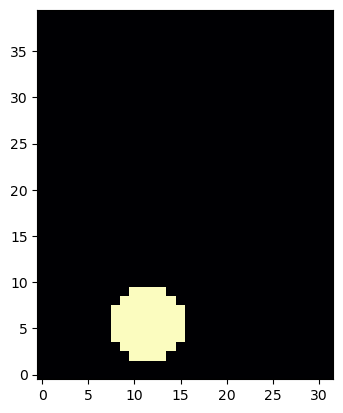

In [66]:
import matplotlib.pyplot as plt
plt.imshow(np.asarray(smoke.values.numpy('y,x')), origin='lower', cmap='magma')

#### Simulation dynamique
* 50 pas de temps
* On sauve l'animation de matplotlib dans un fichier ``.mp4``

In [67]:
import matplotlib.animation as animation
fig, ax = plt.subplots()

ims = []
for time_step in range(100):
    velocity, smoke, pressure = step(velocity, smoke, pressure, dt=DT)
    im = ax.imshow(smoke.values.numpy('y,x'), origin='lower', cmap='magma', animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)

# On tente de sauver un mp4, si cela ne fonctionne pas, on sauve en GIF
try:
    ani.save("data/movie.mp4")
except ValueError:
    from matplotlib.animation import PillowWriter
    writer = PillowWriter(fps=30)
    ani.save("data/smoke.gif", writer=writer)

plt.show()